StableDiffusion for Thermal Images
- UNet + VAE training
- Unconditional Image Generation
- ControlNet training: RGB or greyscale image conditioning for pixelwise correspondence
- Guided Image Generation: RGB or greyscale image
- ControlNet training: adding augmentation # TODO

In [1]:
# prompt: Connect to gdrive and copy folder

from google.colab import drive
drive.mount('/content/drive')
# !ls /content/drive/MyDrive
!cp -r /content/drive/MyDrive/'Colab Notebooks'/SD .

Mounted at /content/drive


Data is two folders (thermal, RGB) with frames corresponding pairwise. The frames (rgb and thermal) have different resolution.

In [ ]:
!unzip SD/lynred_clipped.zip
!unzip SD/gray_clipped.zip

In [1]:
import logging
from tqdm import tqdm
import torch
from pathlib import Path
from diffusers import ControlNetModel, UNet2DConditionModel, AutoencoderKL
from transformers import AutoTokenizer, CLIPTextModel
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir="./runs/exp1")

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

pretrained_model = "stable-diffusion-v1-5/stable-diffusion-v1-5"
pretrained_controlnet = "lllyasviel/control_v11p_sd15_seg"

tokenizer = AutoTokenizer.from_pretrained(pretrained_model, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(pretrained_model, subfolder="text_encoder")
vae = AutoencoderKL(
    in_channels=1,
    out_channels=1,
    down_block_types=("DownEncoderBlock2D", "DownEncoderBlock2D", "DownEncoderBlock2D", "DownEncoderBlock2D"),
    up_block_types=("UpDecoderBlock2D", "UpDecoderBlock2D", "UpDecoderBlock2D", "UpDecoderBlock2D"),
    block_out_channels=(128, 256, 512, 512),
    latent_channels=4,
    norm_num_groups=32,
    sample_size=512
)
checkpoint = torch.load("SD/vae_checkpoint.pt", map_location="cuda")  # or "cuda" if using GPU
vae.load_state_dict(checkpoint["vae_state_dict"])

unet = UNet2DConditionModel.from_pretrained(pretrained_model, subfolder="unet")
checkpoint = torch.load("SD/unet_checkpoint.pt", map_location="cuda")  # or "cuda" if using GPU
unet.load_state_dict(checkpoint["unet_state_dict"])

optimizer = torch.optim.AdamW((list(vae.parameters()) + list(unet.parameters())), lr=1e-5)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
source_dir = "gray_clipped"
target_dir = "lynred_clipped"

batch_size = 8

class PairedDataset(torch.utils.data.Dataset):
    def __init__(self, source_dir, target_dir, image_size=512):
        self.source_paths = sorted(list(Path(source_dir).glob("*.png")))
        self.target_paths = sorted(list(Path(target_dir).glob("*.png")))
        self.transform_thermal = transforms.Compose([
            transforms.Resize((256, 440)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])

        ])
        self.transform_rgb = transforms.Compose([
            transforms.Resize((256, 440)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

        overfit = True
        self.source_paths = self.source_paths[:32] if overfit else self.source_paths
        self.target_paths = self.target_paths[:32] if overfit else self.target_paths
        # print(self.source_paths)

    def __len__(self):
        return len(self.source_paths)
    def __getitem__(self, idx):
        src = Image.open(self.source_paths[idx]).convert("RGB")
        tgt = Image.open(self.target_paths[idx]).convert("RGB")
        return {
            "conditioning_pixel_values": self.transform_rgb(src),
            "pixel_values": self.transform_thermal(tgt),
            "input_ids": tokenizer(
                "", return_tensors="pt", padding="max_length", truncation=True, max_length=tokenizer.model_max_length
            ).input_ids[0]
        }

dataset = PairedDataset(source_dir, target_dir)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 500/500 [18:19<00:00,  2.20s/it]


Training VAE and finetuning UNet

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = vae.to(device)
unet = unet.to(device)
text_encoder = text_encoder.to(device)

global_step = 0
vae.train()
unet.train()
for epoch in tqdm(range(500)):  # set your number of epochs
    for batch in dataloader:
        optimizer.zero_grad()
        pixel_values = batch["pixel_values"].to(device)
        conditioning_pixel_values = batch["conditioning_pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)

        # 1. Encode target (thermal) image to latent space
        with torch.no_grad():
            latents = vae.encode(pixel_values).latent_dist.sample()
            latents = latents * vae.config.scaling_factor
            encoder_hidden_states = text_encoder(input_ids)[0]

        # 2. Add noise
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, 1000, (latents.shape[0],), device=latents.device).long()
        noisy_latents = latents + noise  # For real training, use a scheduler

        # 4. Predict noise with UNet
        model_pred = unet(
            noisy_latents,
            timesteps,
            encoder_hidden_states=encoder_hidden_states,
            return_dict=False,
        )[0]

        # 2. Decode latents back to image space
        recon_images = vae.decode(latents / vae.config.scaling_factor).sample

        # 3. Compute reconstruction loss (MSE between recon_images and pixel_values)
        loss = torch.nn.functional.mse_loss(recon_images, pixel_values, reduction="mean")
        loss.backward()
        optimizer.step()

        # 6. Log loss to TensorBoard
        writer.add_scalar("Loss/train", loss.item(), global_step)
        logger.info(f"Step {global_step} Loss: {loss.item()}")
        global_step += 1

logger.info("Training complete.")
writer.close()

Inference: test unconditional image generation

Output size torch.Size([1, 1, 256, 440])


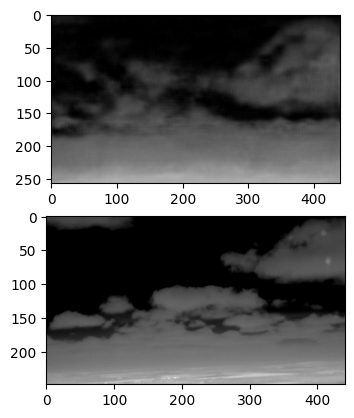

In [4]:
import matplotlib.pyplot as plt
import numpy

# controlnet.eval()
unet.eval()
vae.eval()

def tensor_to_pil(img_tensor):
    # img_tensor: shape (1, H, W), range [-1, 1]
    img = img_tensor.clone().detach().cpu()
    img = img * 0.5 + 0.5  # Unnormalize to [0, 1]
    img = img.squeeze(0)   # Remove channel dim if present
    img = transforms.ToPILImage(mode="L")(img)
    return img

with torch.no_grad():
    validation_grayscale_path = source_dir + "/000000.png"
    thermo_path = target_dir + "/000000.png"

    validation_img = Image.open(thermo_path).convert("RGB")

    validation_tensor = dataset.transform_thermal(validation_img).unsqueeze(0).to(device)
    val_input_ids = tokenizer(
        "", return_tensors="pt", padding="max_length", truncation=True, max_length=tokenizer.model_max_length
    ).input_ids.to(device)

    val_encoder_hidden_states = text_encoder(val_input_ids)[0]
    val_latents = vae.encode(validation_tensor).latent_dist.sample()
    val_latents = val_latents * vae.config.scaling_factor
    val_noise = torch.zeros_like(val_latents)
    val_timesteps = torch.zeros((1,), dtype=torch.long, device=device)

    val_model_pred = unet(
        val_latents,
        val_timesteps,
        encoder_hidden_states=val_encoder_hidden_states,
        return_dict=False,
    )[0]
    val_denoised_latents = val_latents - val_model_pred
    val_image = vae.decode(val_denoised_latents / vae.config.scaling_factor).sample
    val_image = (val_image.clamp(-1, 1) + 1) / 2  # [-1,1] -> [0,1]
    val_image = val_image.cpu()
    vis_image = (val_image.squeeze().unsqueeze(dim=0).permute(1, 2, 0).numpy())
    vis_image = (vis_image * 255).astype(numpy.uint8)
    vis_image = Image.fromarray(vis_image[:, :, 0], mode='L').convert("RGB")
    print('Output size', val_image.shape)

# plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,1)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(vis_image)
axarr[1].imshow(validation_img)
# axarr[2].imshow(val_image.squeeze())

Output size torch.Size([1, 1, 256, 440])


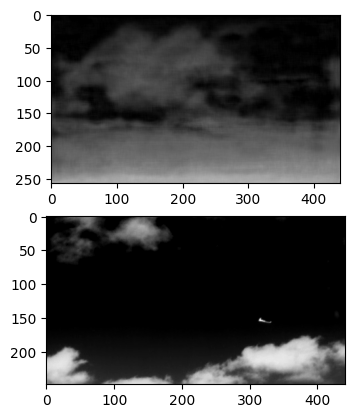

In [10]:
import matplotlib.pyplot as plt
import numpy


with torch.no_grad():
    validation_grayscale_path = source_dir + "/000901.png"
    thermo_path = target_dir + "/000901.png"

    validation_img = Image.open(thermo_path).convert("RGB")

    validation_tensor = dataset.transform_thermal(validation_img).unsqueeze(0).to(device)
    val_input_ids = tokenizer(
        "", return_tensors="pt", padding="max_length", truncation=True, max_length=tokenizer.model_max_length
    ).input_ids.to(device)

    val_encoder_hidden_states = text_encoder(val_input_ids)[0]
    val_latents = vae.encode(validation_tensor).latent_dist.sample()
    val_latents = val_latents * vae.config.scaling_factor
    val_noise = torch.zeros_like(val_latents)
    val_timesteps = torch.zeros((1,), dtype=torch.long, device=device)

    val_model_pred = unet(
        val_latents,
        val_timesteps,
        encoder_hidden_states=val_encoder_hidden_states,
        return_dict=False,
    )[0]
    val_denoised_latents = val_latents - val_model_pred
    val_image = vae.decode(val_denoised_latents / vae.config.scaling_factor).sample
    val_image = (val_image.clamp(-1, 1) + 1) / 2  # [-1,1] -> [0,1]
    val_image = val_image.cpu()
    vis_image = (val_image.squeeze().unsqueeze(dim=0).permute(1, 2, 0).numpy())
    vis_image = (vis_image * 255).astype(numpy.uint8)
    vis_image = Image.fromarray(vis_image[:, :, 0], mode='L').convert("RGB")
    print('Output size', val_image.shape)

# plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,1)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(vis_image)
axarr[1].imshow(validation_img)
# axarr[2].imshow(val_image.squeeze())

Save VAE and UNET

In [41]:
# Save VAE model checkpoint
vae_ckpt_path = "SD/vae_checkpoint.pt"
torch.save({
    "vae_state_dict": vae.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "global_step": global_step,
}, vae_ckpt_path)
logger.info(f"VAE checkpoint saved at {vae_ckpt_path}")

In [42]:
# Save UNet model checkpoint
unet_ckpt_path = "SD/unet_checkpoint.pt"
torch.save({
    "unet_state_dict": unet.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "global_step": global_step,
}, unet_ckpt_path)
logger.info(f"UNet checkpoint saved at {unet_ckpt_path}")

Train ControlNet

In [43]:
!cp SD/unet_checkpoint.pt drive/MyDrive/Colab\ Notebooks/SD
!cp SD/vae_checkpoint.pt drive/MyDrive/Colab\ Notebooks/SD
# !cp drive/MyDrive/Colab\ Notebooks/SD/control_v11e_sd15_ip2p.pth SD/

In [57]:
!cp drive/MyDrive/Colab\ Notebooks/SD/control_v11e_sd15_ip2p.pth SD/

In [ ]:
pretrained_controlnet = "lllyasviel/control_v11e_sd15_ip2p" # 'lllyasviel/control_v11p_sd15_seg.pth' for future - also segmentation
checkpoint = torch.load(pretrained_controlnet, map_location="cuda")  # or "cuda" if using GPU
controlnet = ControlNetModel.from_pretrained(pretrained_controlnet)

checkpoint = torch.load("SD/controlnet_checkpoint.pt", map_location="cuda")  # or "cuda" if using GPU
controlnet.load_state_dict(checkpoint["controlnet_state_dict"])
controlnet = controlnet.to(device)

In [ ]:
global_step = 0

controlnet.train()
vae.to(device)
text_encoder.to(device)
controlnet.to(device)

# For now, trying to only finetune ControlNet in isolation
# because data calls for domain adaptation and rgb-conditioning 
# is already trained. Maybe would have to finetune all components
for param in vae.parameters():
    param.requires_grad = False
for param in unet.parameters():
    param.requires_grad = False
for param in text_encoder.parameters():
    param.requires_grad = False
for param in controlnet.parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW((list(controlnet.parameters())), lr=1e-5)

for epoch in tqdm(range(500)):
    for batch in dataloader:
        optimizer.zero_grad()
        pixel_values = batch["pixel_values"].to(device)
        conditioning_pixel_values = batch["conditioning_pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)

        # 1. Encode target (thermal) image to latent space
        with torch.no_grad():
            latents = vae.encode(pixel_values).latent_dist.sample()
            latents = latents * vae.config.scaling_factor
            encoder_hidden_states = text_encoder(input_ids)[0]

        # 2. Add noise
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, 1000, (latents.shape[0],), device=latents.device).long()
        noisy_latents = latents + noise  # For real training, use a scheduler

        # 3. Forward pass through ControlNet
        down_block_res_samples, mid_block_res_sample = controlnet(
            noisy_latents,
            timesteps,
            encoder_hidden_states=encoder_hidden_states,
            controlnet_cond=conditioning_pixel_values,
            return_dict=False,
        )

        # 4. Predict noise with UNet
        model_pred = unet(
            noisy_latents,
            timesteps,
            encoder_hidden_states=encoder_hidden_states,
            down_block_additional_residuals=[s for s in down_block_res_samples],
            mid_block_additional_residual=mid_block_res_sample,
            return_dict=False,
        )[0]

        # 5. Compute loss (MSE between predicted and true noise)
        loss = torch.nn.functional.mse_loss(model_pred.float(), noise.float(), reduction="mean")
        loss.backward()
        optimizer.step()

        # 6. Log loss to TensorBoard
        writer.add_scalar("Loss/train", loss.item(), global_step)
        logger.info(f"Step {global_step} Loss: {loss.item()}")
        global_step += 1

logger.info("Training complete.")
writer.close()

  0%|          | 1/500 [06:10<51:22:43, 370.67s/it]


KeyboardInterrupt: 

In [71]:
# Save UNet model checkpoint
cnet_ckpt_path = "SD/controlnet_checkpoint.pt"
torch.save({
    "controlnet_state_dict": controlnet.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "global_step": global_step,
}, cnet_ckpt_path)
logger.info(f"UNet checkpoint saved at {cnet_ckpt_path}")

Test out trained conditioning.

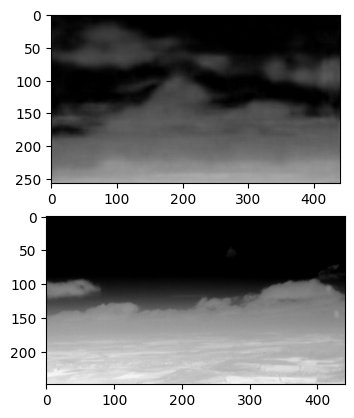

In [ ]:
import matplotlib.pyplot as plt

controlnet.eval()
unet.eval()
vae.eval()

with torch.no_grad():
    validation_grayscale_path = source_dir + "/005901.png"
    thermo_path = target_dir + "/005901.png"

    validation_img = Image.open(thermo_path).convert("RGB")
    condition_image = Image.open(validation_grayscale_path).convert("RGB")

    validation_tensor = dataset.transform_thermal(validation_img).unsqueeze(0).to(device)
    condition_tensor = dataset.transform_rgb(condition_image).unsqueeze(0).to(device)

    val_input_ids = tokenizer(
        "", return_tensors="pt", padding="max_length", truncation=True, max_length=tokenizer.model_max_length
    ).input_ids.to(device)

    val_encoder_hidden_states = text_encoder(val_input_ids)[0]
    val_latents = vae.encode(validation_tensor).latent_dist.sample()
    val_latents = val_latents * vae.config.scaling_factor
    val_noise = torch.zeros_like(val_latents)
    val_timesteps = torch.zeros((1,), dtype=torch.long, device=device)

    val_down_block_res_samples, val_mid_block_res_sample = controlnet(
        val_latents,
        val_timesteps,
        encoder_hidden_states=val_encoder_hidden_states,
        controlnet_cond=condition_tensor,
        return_dict=False,
    )
    val_model_pred = unet(
        val_latents,
        val_timesteps,
        encoder_hidden_states=val_encoder_hidden_states,
        down_block_additional_residuals=[s for s in val_down_block_res_samples],
        mid_block_additional_residual=val_mid_block_res_sample,
        return_dict=False,
    )[0]
    val_denoised_latents = val_latents - val_model_pred
    val_image = vae.decode(val_denoised_latents / vae.config.scaling_factor).sample
    val_image = (val_image.clamp(-1, 1) + 1) / 2  # [-1,1] -> [0,1]
    val_image = val_image.cpu()
    vis_image = (val_image.squeeze().unsqueeze(dim=0).permute(1, 2, 0).numpy())
    vis_image = (vis_image * 255).astype(numpy.uint8)
    vis_image = Image.fromarray(vis_image[:, :, 0], mode='L').convert("RGB")

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,1)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(vis_image)
axarr[1].imshow(validation_img)

TODO: add noise from already pretrained ControlNet (trained for segmentation masks conditioning) and finetune the generation (all components or unet and vae)